In [1]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
import os
path = os.getcwd()
import json

import matplotlib as mpl
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
mpl.rcParams['legend.fontsize'] = 10
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
!python -V

Python 3.12.4


In [3]:
def Frobenius(A,B):
    return torch.vmap(torch.trace)(torch.bmm(A,torch.transpose(B,1,2)))

# Random number generation

In [4]:
t0 = time.time()
num_samples = 2**16
num_time_intervals = 30
max_dim = 10
size = num_samples* max_dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))

It takes 197 ms to generate 19,660,800 iid samples.


# Parameters of the PDEs

In [5]:
# dim = n+1, n assets, 1 wealth + n stochastic volatilites. does not include time
# PDE
pde_params={'dim':5,
            'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
            'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
            # 'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device), #Hung's coefficient
            'nu':torch.tensor([0.2,0.15,0.11,0.12,0.1,0.13,0.14,0.14,0.1]).to(device), # we do not like vanishing diffusion coefficient
            # 'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   Hung's params
            'lb':torch.tensor([0.,1.15,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device), # New params Make closed form solution more sensitive to time
            'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
            'eta':torch.tensor([1.]).to(device),
            'T': 1.,#torch.tensor([1.]).to(device),
            }

# Parameters of simulation

In [6]:
sim_params={'num_samples':2**9,
        'num_time_intervals': 10,
        'iid':iid,
        'start' : torch.tensor([0.0]),  
        'end' : torch.tensor([1.0]),
        'num_neurons':4
        }

In [7]:
step = pde_params['T']/sim_params['num_time_intervals']


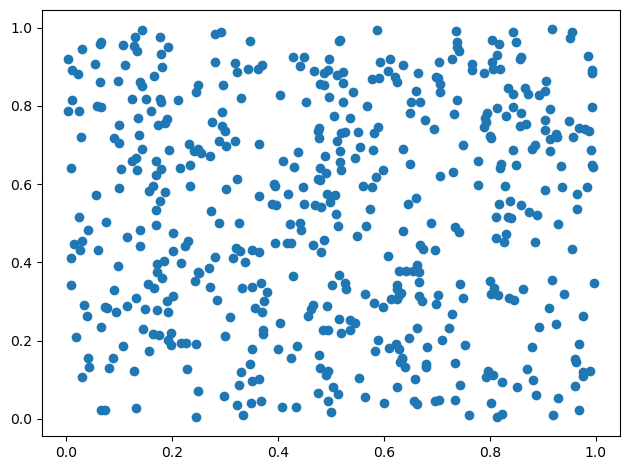

In [8]:
a = sim_params['start']
b = sim_params['end']
dim = 20
x0 = a+(b-a)*torch.rand(sim_params['num_samples'],dim).to(device)
plt.scatter(x0[:,0].numpy(),x0[:,dim-1].numpy());
plt.tight_layout(rect=[0,0,1,1]);

# First and second derivatives

In [9]:


def Grad(x,v): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    d = x.shape[1]
    Du=torch.zeros(x.shape[0],d).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=v(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    Du = torch.reshape(Du,(Du.shape[0],d,1))
    return Du

def Grad_Hess(x,v): #output= [M,D,D], #input: x=[M,D], t=[M,1], xt= [M,D+1]
    d = x.shape[1]
    hess_temp=torch.zeros(x.shape[0],d,d).to(device)
    Du=torch.zeros(x.shape[0],d).to(device)
    xin=x.clone().detach()
    xin.requires_grad=True
    u=v(xin)
    Du=torch.autograd.grad(outputs=[u],inputs=[xin],grad_outputs=torch.ones_like(u),
                           allow_unused=True,retain_graph=True,create_graph=True)[0].unsqueeze(2)
    hess_temp= torch.cat([torch.autograd.grad(outputs=[Du[:,i,:]],inputs=[xin],grad_outputs=torch.ones_like(Du[:,i,:]),
                           allow_unused=True,retain_graph=True,create_graph=True)[0] for i in range(d)],1)
    Du = torch.reshape(Du,(Du.shape[0],d,1))
    hess_temp=torch.reshape(hess_temp,(hess_temp.shape[0],d,d))
    return Du, hess_temp

# Functions: Neural nets and closed-froms

In [10]:
'''Class to create functions which take parameters from a dictionary'''
class solution(object):
    def __init__(self,params):
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa'][0:self.dim]
        self.theta = params['theta'][0:self.dim]
        self.eta = params['eta']
        self.lb = params['lb'][0:self.dim]
        self.T = params['T']
        
        
class exp_solution(solution):
    def __init__(self,params,alpha):
        self.alpha = alpha
        super(exp_solution, self).__init__(params)
    def __call__(self,x):
        # print(self.alpha)
        return torch.tensor([1.])-torch.exp(-self.eta*x[:,1]+self.alpha*(self.T-x[:,0])).to(device)     

class zero_solution(solution):
    def __init__(self,params):
        super(zero_solution, self).__init__(params)
    def __call__(self,x):
        # print(self.alpha)
        return torch.zeros([x.shape[0],1]).to(device) 
    
class time_solution(solution):
    def __init__(self,params,constant):
        self.constant = constant
        super(time_solution, self).__init__(params)
    def __call__(self,x):
        return (self.T-x[:,0].unsqueeze(-1))*self.constant*torch.ones([x.shape[0],1]).to(device)    

class Ynet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,pde,sim):
        super(Ynet, self).__init__()
        dim = pde['dim']
        num_neurons = sim['num_neurons']
        self.linear_stack = nn.Sequential(
            nn.Linear(dim, num_neurons),
            # nn.BatchNorm1d(num_features=8),# We should never use Batch mormalization in these type of problems when the input and scale back to a smaller region. The input is normalized with a different scale than the training data and out functions are going to be screwed.
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(num_neurons,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits  
    
    
# derivative of the solution at all times
class Znet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,pde,sim):
        dim = pde['dim']
        num_neurons = sim['num_neurons']
        super(Znet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            # nn.BatchNorm1d(num_features=20),
            nn.Tanh(),
            nn.Linear(num_neurons,dim),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits#.reshape([dim,dim])  
    
    
# Value of the solution at all times
class Ytnet(nn.Module): #input [M,D+1]   #output [M,1]
    def __init__(self,pde,sim):
        dim = pde['dim']
        num_neurons = sim['num_neurons']
        super(Ytnet, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(dim+1, num_neurons),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            nn.Tanh(),
            nn.Linear(num_neurons, num_neurons),
            # nn.BatchNorm1d(num_features=8),
            nn.Tanh(),
            nn.Linear(num_neurons,1),
        )
    def forward(self, x):
        logits = self.linear_stack(x)
        return logits  

In [11]:
class test(solution):
    def __init__(self,params,g,Y):
        self.g = g
        self.Y = Y
        super(test,self).__init__(params)
    def __call__(self,x):
        return self.g(x[:,1:]) + self.Y(x)*(self.T-x[:,0]).unsqueeze(-1)
    

In [12]:
# Y = Ytnet(pde_params,sim_params)
# g = zero_terminal(pde_params)
# t = test(pde_params,g,Y)

In [13]:
# input = torch.tensor([[0.,.1,.1],[0.1,0.2,0.4]])
# t(input)

# Coefficients and boundary values

In [14]:
'''Implements the coefficeints based on the parameters '''
class coefficient(object):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa'][0:self.dim]
        self.theta = params['theta'][0:self.dim]
        self.eta = params['eta']
        self.lb = params['lb'][0:self.dim]
        self.lb_norm = torch.sqrt(torch.pow(params['lb'][0:self.dim],2).sum())
        self.params = params
    def __call__(self,x):
        pass
    def __add__(self, other):
        tmp = coefficient(self.params)
        tmp.__call__ = lambda x : self(x) + other(x)
        return tmp
        
    


## Diffusion

In [15]:
# '''constant diffution coefficient'''  
# class constant_diff(coefficient):
#     '''This class is a constant diffusion coefficient which is the optimal diffusion'''
#     def __init__(self,params,**kwargs):
#         super(constant_diff, self).__init__(params)
#         if kwargs:
#             if 'constant_diff' in kwargs.keys():
#                 self.diff = kwargs['constant_diff']
#             else:
#                 self.diff = torch.sqrt(torch.pow(self.lb,2).sum())/self.eta
#         else:
#             self.diff = torch.sqrt(torch.pow(self.lb,2).sum())/self.eta
#     def __call__(self,x):
#         tmp = x.shape[0]
#         return torch.diag(torch.cat((self.diff,self.nu[0:self.dim-1]),axis=0)).repeat(tmp,1,1)

# '''Random diffusion coefficient for wealth process with diffusion of volatility processes all constant'''   
# class random_diff(coefficient):
#     def __init__(self,params):
#         super(random_diff, self).__init__(params)
#     def __call__(self,x):
#         tmp = x.shape[0]
#         return torch.diag(torch.cat((torch.rand(tmp,1),self.nu[0:self.dim-1].repeat(tmp,1)),axis=0)) 

''' diffusion'''
class custom_diff(coefficient):
    def __init__(self, params,s):
        super(custom_diff, self).__init__(params)
        if torch.is_tensor(s):
            self.val = lambda x:s
        else:
            self.val = s
    def __call__(self, x):
        dim = self.params['dim']
        num_samples = x.shape[0]
        A=torch.zeros(num_samples,dim,dim)
        A[:,1:,1:] = torch.diag(self.params['nu'][0:dim-1])
        A[:,0,0] = self.val(x)
        return A
    def __add__(self, other):
        tmp = lambda x : self.val(x) + other.val(x)
        return custom_diff(self.params,tmp)
    
    
# '''Zero drift coefficient for all components'''  
# class zero_drift(coefficient):
#     def __init__(self,params):
#         super(zero_drift, self).__init__(params)
#     def __call__(self,x):
#         return torch.zeros(x.shape[0],x.shape[1]-1)
    
    


## Drift

In [16]:
'''Drift of linear eqn: first component drift =|lb|*sgn(v_e)sigma_{00}(x), others are OU'''
class OU_drift_lin(coefficient):
    def __init__(self,params,v,sigma):
        self.p = v
        self.sigma = sigma
        super(OU_drift_lin, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        q = self.p(x)[:,0]
        output = torch.zeros(num_samples,self.dim)
        output[:,0] = torch.sqrt(torch.pow(self.lb,2).sum())*torch.sgn(q)*self.sigma(x)[:,0,0]
        for i in range(1,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i+1])
        return output 
    
'''Drift of semilinear eqn: first component drift=0, others are OU'''
class OU_drift_semi(coefficient):
    def __init__(self,params):
        super(OU_drift_semi, self).__init__(params)
    def __call__(self,x):
        num_samples = x.shape[0]
        output = torch.zeros(num_samples,self.dim)
        for i in range(0,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i+1])
        return output
 
    
'''Basically does same thing as OU_drift_lin. But one can simply change it.'''  
class custom_drift(coefficient):
    def __init__(self, params,s,sigma):
        super(custom_drift, self).__init__(params)
        if torch.is_tensor(s):
            self.s = lambda x:s
        else:
            self.s = s
            if torch.is_tensor(sigma):
                self.sigma = lambda x:sigma
            else:
                self.sigma = sigma
            self.lb_norm = torch.sqrt(torch.pow(params['lb'][0:params['dim']],2).sum())
    def val(self,x): 
        return self.lb_norm*torch.sgn(Grad(x,self.s)[:,1].squeeze(-1))
    def __call__(self, x):
        num_samples = x.shape[0]
        output = torch.zeros(num_samples,self.dim)
        for i in range(1,self.dim):
            output[:,i] = self.kappa[i]*(self.theta[i] - x[:,i+1])
        output[:,0] = self.val(x)
        return output    

## Source

In [17]:
class zero_source(coefficient):
    def __init__(self,params):
        super(zero_source, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)   
    
class custom_source(coefficient):
    def __init__(self,params,source):
        if torch.is_tensor(source):
            self.val = lambda x:source 
        else:
            self.val = source
        super(custom_source, self).__init__(params)
    def __call__(self,x):
        return self.val(x) 

## Direction

In [18]:
class direction(coefficient):
    def __init__(self,params,v,sigma,**kwargs):
        self.p = v# we need to evaluate gradient and hessian of v
        self.sigma = sigma
        if kwargs:
            if 'magnitude' in kwargs:
                magnitude = kwargs['magnitude']
                if torch.is_tensor(magnitude)|isinstance(magnitude, float):
                    if isinstance(magnitude, float):
                        magnitude = torch.tensor(magnitude)
                    self.magnitude = lambda x:magnitude.repeat(x.shape[0],1)
                else:
                    self.magnitude = magnitude
            if 'bound' in kwargs:
                bound = kwargs['bound']
                if torch.is_tensor(bound)|isinstance(bound, float):
                    if isinstance(bound, float):
                        bound = torch.tensor(bound)
                    self.bound = lambda x:bound.repeat(x.shape[0],1)
                else:
                    self.bound = bound      
        else:
            self.magnitude = lambda x:torch.ones(x.shape[0],1)
            self.bound = lambda x:2*torch.ones(x.shape[0],1)          
        super(direction, self).__init__(params)
    def val(self,x):
        D2 = Grad_Hess(x,self.p)[1][:,1,1]
        D1 = Grad_Hess(x,self.p)[0][:,1]
        return torch.maximum(torch.minimum(self.magnitude(x).squeeze(-1)*(self.lb_norm*torch.abs(D1.squeeze(-1))+self.sigma(x)[:,0,0]*D2),self.bound(x).squeeze(-1)), torch.zeros(x.shape[0])) 

    def __call__(self,x):
        A = torch.zeros(x.shape[0],self.dim,self.dim)
        # print(self.magnitude(x).shape,(self.lb_norm*torch.abs(D1.squeeze(-1))+self.sigma(x)[:,0,0]*D2).shape)
        A[:,0,0] = self.val(x)
        return A   
    def __mul__(self, magnitude):
        return direction(self.params,self.p,self.sigma,magnitude=magnitude,bound=self.bound)
    def __rmul__(self, magnitude):
        return direction(self.params,self.p,self.sigma,magnitude=magnitude,bound=self.bound)
        



In [19]:
        
class source_from_direction(coefficient): # source term for the linear equations
    def __init__(self,params,direction):
        # self.alpha = direction.magnitude
        self.direction = direction
        super(source_from_direction, self).__init__(params)
    def __call__(self,x):
        A = self.direction(x)
        return -torch.sqrt(Frobenius(A,A)).unsqueeze(-1)
        
'''Zero discount coefficient for all components'''  
class zero_discount(coefficient):
    def __init__(self,params):
        super(zero_discount, self).__init__(params)
    def __call__(self,x):
        return torch.zeros(x.shape[0],1)     
    
'''Driver for a semilinear'''               
class f_driver(coefficient):
    def __init__(self,params): #### out_shape =([M]) |  input:  x_shape=[M,D,1],  z shape = [M,D,1],a_shape= [M,D,D]  #This is for rho=0
        super(f_driver, self).__init__(params)
    def __call__(self,z,a):
        return -torch.sqrt(torch.sum(torch.square(self.lb)))*torch.abs(z[:,0,0])*torch.abs(a)# + output
        
    
'''Adding two coefficients together'''
class adjust_coeff(coefficient):
    def __init__(self,s1,s2,c):
        self.s1 = s1
        self.s2 = s2
        self.constant = c
        super(adjust_coeff, self).__init__(s1.params)
    def __call__(self,x):
        return self.s1(x)+self.constant*self.s2(x)
        
'''Terminal functions'''        
class exponential_terminal(coefficient):
    def __init__(self,params):
        self.eta = params['eta']
    def __call__(self,x):
        return (torch.tensor([1.])-torch.exp(-self.eta*x[:,0])).unsqueeze(-1)            
    
class zero_terminal(coefficient):
    def __init__(self,params):
        self.eta = params['eta']
    def __call__(self,x):
        num_samples = x.shape[0]
        return torch.zeros(num_samples,1)
    
    
class solution(object):
    def __init__(self,params):
        self.dim=params['dim']#2
        self.nu = params['nu']
        self.kappa = params['kappa'][0:self.dim]
        self.theta = params['theta'][0:self.dim]
        self.eta = params['eta']
        self.lb = params['lb'][0:self.dim]
        self.T = params['T']
        
        
class exp_solution(solution):
    def __init__(self,params,alpha):
        self.alpha = alpha
        super(exp_solution, self).__init__(params)
    def __call__(self,x):
        # print(self.alpha)
        return torch.tensor([1.])-torch.exp(-self.eta*x[:,1]+self.alpha*(self.T-x[:,0])).to(device)     

class zero_solution(solution):
    def __init__(self,params):
        super(zero_solution, self).__init__(params)
    def __call__(self,x):
        # print(self.alpha)
        return torch.zeros([x.shape[0],1]).to(device) 
    
class time_solution(solution):
    def __init__(self,params,constant):
        self.constant = constant
        super(time_solution, self).__init__(params)
    def __call__(self,x):
        return (self.T-x[:,0].unsqueeze(-1))*self.constant*torch.ones([x.shape[0],1]).to(device)        
    
    
    

# Sample path generation

In [20]:
class data_gen(object):
    def __init__(self,sigma,mu,pde,sim):
        self.mu = mu
        self.sigma = sigma
        a = sim['start']
        b = sim['end']
        iid = sim['iid']
        num_samples = sim['num_samples']
        n = sim['num_time_intervals']
        dim = pde['dim']
        self.dt = torch.tensor([pde['T']/sim['num_time_intervals']]).to(device)
        dw = iid[0:num_samples*dim*n].reshape([num_samples,dim,n]).to(device)* torch.sqrt(self.dt)#you can make randomness a universal variable if 
        self.x = torch.zeros((num_samples,dim+1,n+1))
        
        self.x[:,1:,0]= a+(b-a)*torch.rand(num_samples,dim).to(device)  
        self.sigmadw = torch.zeros((num_samples,dim,n)).to(device)
        for i in range(n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((num_samples,dim,dim)),dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt

# Equations (linear/semilinear)

$\begin{cases}-\partial v_t - \dfrac12 (\sigma^\intercal\sigma): D^2v -\mu\cdot\nabla v + f(t,x,v(t,x),\nabla v(t,x)) =0\\
v(T,x)=g(x)
\end{cases}$

$\sigma(t,x)$ has shape [num_samples,dim,dim]
$dW_t$  has shape [num_samples,dim]

We need to unsqueeze $dW_t$ before batch multiplication.

    
    torch.bmm(sigma(x[:,:,i]),dw[:, :, i]dw[:, :, i].unsqueeze(2))



In [21]:
class parabolic(object):
    def __init__(self,sigma,mu,kappa,terminal,pde,sim):        
        self.Y0 = Ynet(pde,sim) # NN for value at t=0 
        # self.Z = Znet(pde,sim) # NN for gradient at all times
        self.Yt = Ytnet(pde,sim) # NN for value function at all times, required to update sigma
        self.terminal = terminal # terminal condition
        self.loss_epoch = [] # list to keep the loss at each training epoch
        self.epoch=0 # initializing epoch to zero
        # self.num_epochs = 5000 # total number of epochs
        self.mu = mu # drift of the SDE
        self.sigma = sigma # diffusion coef. for SDE
        self.kappa = kappa # discount factor
        self.n = sim['num_time_intervals'] # number of time intervals
        self.dim = pde['dim']
        self.num_samples = sim['num_samples']
        data = data_gen(sigma,mu,pde,sim)
        self.dt = data.dt.to(device)
        self.x = data.x.to(device).clone().detach()
        self.sigmadw = data.sigmadw.to(device).clone().detach()
        self.r = torch.ones((self.x.shape[0],1,self.n+1)).to(device)
        for i in range(self.n):
            self.r[:,:,i+1] = self.r[:,:,i]* torch.exp(-self.kappa(self.x[:,:,i])*self.dt)
        self.r = self.r.clone().detach()
        self.trained = False
        self.params = {**copy.deepcopy(pde),**copy.deepcopy(sim)} 
        
    def train(self,lr,delta_loss,max_num_epochs):
        t_0 = time.time()
        self.lr = lr
        parameters = list(self.Y0.parameters()) + list(self.Yt.parameters())
        optimizer = optim.Adam(parameters, self.lr)
        L_ = -2.0
        L = 2.0
        while (np.abs(L_-L)>delta_loss) & (self.epoch < max_num_epochs):# epoch in range(num_epochs):
            t_1 = time.time()
            optimizer.zero_grad()
            if self.epoch>0:
                L_ = self.loss_epoch[self.epoch-1]
            loss= self.loss()#self.cost(self.X,self.modelu(X))+ torch.mean(self.terminal(update(self.X,self.modelu(X))))#
            loss.backward()
            optimizer.step()
            L = loss.clone().detach().numpy()
            self.loss_epoch.append(L)
            if (self.epoch % int(max_num_epochs/3)== int(max_num_epochs/3)-1) | (self.epoch == 0):
                print('At epoch {}, mean loss is {:.2E}.'.format(self.epoch+1,L))
                self.time_display(t_0, t_1)
            self.epoch += 1
        t_delta = time.time()-t_0
        print(r'Training took {} epochs and {:,} ms and the final loss is {:.2E}.'.format(self.epoch,round(1000*(t_delta),2),loss))
        self.trained = True
        # self.value_fnc(lr=1e-2,delta_loss=delta_loss,max_num_epochs=1000,num_batches=10)
        self.params['Y0'] = self.Y0
        # self.params['Z'] = self.Z
        self.params['value'] = self.Yt
        self.params['training_time'] = t_delta
        self.params['loss'] = self.loss_epoch
        self.params['max_epochs'] = self.epoch
        

    def time_display(self, t_0, t_1):
        print(r'Training this epoch takes {:,} ms. So far: {:,} ms in training.'.format(round(1000*(time.time()-t_1),2),round(1000*(time.time()-t_0),2)))
        

class linear(parabolic):
    def __init__(self, sigma, mu, source, kappa, terminal, pde, sim):
        self.source = source # source term for the PDE
        super().__init__(sigma, mu, kappa, terminal, pde, sim)  
        self.c = torch.ones((self.x.shape[0],1,self.n+1)).to(device)
        for i in range(self.n):
            if i == self.n -1 :
                self.c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
            self.c[:,:,i] = self.source(self.x[:,:,i])
        self.c = self.c.clone().detach()  
        
    def loss(self):
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                Z = Grad(self.x[:,:,i-1],self.Yt)[:,1:,:].view(-1,1,self.dim)
                Y = Y*self.r[:,:,i] + self.c[:,:,i-1]*self.dt + torch.bmm(Z,self.sigmadw[:,:,i-1].unsqueeze(2)).squeeze(2)
                if i == self.n-1:
                    Z = Grad(self.x[:,:,i],self.Yt)[:,1:,:].view(-1,1,self.dim)
                    Y = Y*self.r[:,:,i] + self.c[:,:,i]*self.dt + torch.bmm(Z,self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
        L1 = torch.pow(self.c[:,:,-1]-Y,2)
        L2 = torch.pow(self.Y0(self.x[:,1:,0])-self.Yt(self.x[:,:,0]),2)# Match with Y0
        L3 = torch.pow(self.c[:,:,-1]-self.Yt(self.x[:,:,-1]),2) # match with terminal
        L = L1 + L2 + L3
        return L.mean()        
    
class semilinear(parabolic):
    def __init__(self,sigma, mu, driver, kappa, terminal, pde, sim):
        self.F = driver    
        super(semilinear,self).__init__(sigma, mu, kappa, terminal, pde, sim)   
        self.sigmax = torch.ones((self.x.shape[0],self.dim,self.dim,self.n)).to(device)
        for i in range(self.n):
            #evaluate and reuse self.sigma(self.x[:,:,i]).reshape((self.num_samples,self.dim,self.dim))[:,0,0] 
            self.sigmax[:,:,:,i] = self.sigma(self.x[:,:,i]).reshape((self.num_samples,self.dim,self.dim))
        self.sigmax = self.sigmax.clone().detach()
        
    def loss(self):
        c = torch.zeros((self.num_samples,1,self.n+1)).to(device)
        for i in range(self.n):   
            if i == 0:
                Y =  self.Y0(self.x[:,1:,0])
            else:
                Z = Grad(self.x[:,:,i-1],self.Yt)[:,1:,:].view(-1,1,self.dim)                    
                c[:,:,i-1] = self.F(Z,self.sigmax[:,0,0,i-1]).unsqueeze(-1)
                Y = Y*self.r[:,:,i] + c[:,:,i-1]*self.dt + torch.bmm(Z,self.sigmadw[:,:,i-1].unsqueeze(2)).squeeze(2)
                if i == self.n - 1:
                    Z = Grad(self.x[:,:,i],self.Yt)[:,1:,:].view(-1,1,self.dim)                    
                    c[:,:,i] = self.F(Z,self.sigmax[:,0,0,i]).unsqueeze(-1)
                    Y = Y*self.r[:,:,i] + c[:,:,i]*self.dt + torch.bmm(Z,self.sigmadw[:,:,i].unsqueeze(2)).squeeze(2)
                    c[:,:,i+1] = self.terminal(self.x[:,1:,i+1])
        L1 = torch.pow(c[:,:,-1]-Y,2)
        L2 = torch.pow(self.Y0(self.x[:,1:,0])-self.Yt(self.x[:,:,0]),2)# Match with Y0
        L3 = torch.pow(c[:,:,-1]-self.Yt(self.x[:,:,-1]),2) # match with terminal
        L = L1 + L2 + L3
        return L.mean()            

# Plot and save

In [22]:
class distance_to_optimal(object):
    def __init__(self,sigma,optimal_sigma,pde, sim):
        self.approx = sigma
        self.target = optimal_sigma
        step = pde['T']/sim['num_time_intervals']
        dim = pde['dim']
        sample_size = 2**10
        for t in np.arange(stop=pde_params['T']+step,step=step):
            t_ = torch.tensor(t).repeat(sample_size,1)
            if t == 0:
                data = torch.cat((t_,torch.rand(sample_size,dim)),axis=-1)
            else:
                tmp_ = torch.cat((t_,torch.rand(sample_size,pde_params['dim'])),axis=-1)
                data = torch.cat((data,tmp_),axis=0)
        self.err = torch.sqrt(torch.pow(sigma(data) - optimal_sigma(data),2)).mean()
        print(r'The L^2 norm of difference between current sigma and optimal sigma is {:.2E}.'.format(self.err.item()))

        
    def __call__(self,t,**kwargs):
        steps =100
        x = torch.linspace(0.25,0.75,steps=steps)
        y = torch.linspace(0.25,0.75,steps=steps)
        xy = torch.cartesian_prod(x,y)
        self.X, self.Y = torch.meshgrid(x, y, indexing='ij')
        txy = torch.cat((t*torch.ones(xy.shape[0],1),xy),axis=1)
        self.s_opt = self.target(txy)[:,0,0].detach().reshape(steps,steps)
        self.s_new = self.approx(txy)[:,0,0].detach().reshape(steps,steps)
        f = plt.figure(figsize=(6,6),dpi=300);
        ax = f.add_subplot(111, projection='3d');
        ax.plot_surface(self.X.numpy(),self.Y.numpy(),self.s_opt.numpy(),alpha=0.5,label='optimal',color='b');
        ax.plot_surface(self.X.numpy(),self.Y.numpy(),self.s_new.numpy(),alpha=0.5,label='new',color='r');
        legend_loc=(0.0,0.8)
        if kwargs:
            if 'zlim' in kwargs.keys():
                ax.set_zlim(kwargs['zlim'])

            if 'legend_loc' in kwargs.keys():
                legend_loc = kwargs['legend_loc']

        ax.legend(loc=legend_loc)  
        f.suptitle(r'Difference between optimal $\sigma$ vs approximation at time t={:.2f}'.format(t))
        
        


class loss_plot(object):
    def __init__(self,eqn,**kwargs):
        f_log= plt.figure(dpi=300)
        f_log.suptitle(r'Loss function vs epochs')
        ax_log = f_log.add_subplot(111)
        ax_log.plot(np.log(np.arange(len(eqn.loss_epoch))+1),[np.log(l) for l in eqn.loss_epoch]);
        ax_log.set_xlabel(r'$\ln($epoch$)$')
        ax_log.set_ylabel(r'$\ln($loss$)$');
        if kwargs:
            path = os.path.join(kwargs['path'],"log_loss.png")
            if 'path' in kwargs:
                plt.savefig(path,bbox_inches='tight',dpi=300)
                



class display_it(object):
    def __init__(self,eqn,**kwargs):
        t = 0# default time. Change it if kwargs kick in later.
                
        if eqn.dim == 2:
            f = plt.figure(figsize=(6,6),dpi=300);
            ax = f.add_subplot(111, projection='3d')
            ax.set_xlabel('wealth')
            ax.set_ylabel('volatility');
            
            
            steps =100
            x = torch.linspace(0.25,0.75,steps=steps)
            y = torch.linspace(0.25,0.75,steps=steps)
            xy = torch.cartesian_prod(x,y)
            X, Y = torch.meshgrid(x, y, indexing='ij')
            v_T = eqn.terminal(xy).detach().reshape(steps,steps).squeeze(-1)
            ax.plot_surface(X.numpy(),Y.numpy(),v_T.numpy(),alpha=0.5,label='Terminal',color='gray');
            txy = torch.cat((torch.zeros(xy.shape[0],1),xy),axis=1)
            if kwargs:
                if 't' in kwargs.keys():
                    t = kwargs['t']
                    txy = torch.cat((t*torch.ones(xy.shape[0],1),xy),axis=1)
                else:
                    v = eqn.Y0(xy).detach().reshape(steps,steps).squeeze(-1)
                    ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation",color='b');
            else:
                v = eqn.Y0(xy).detach().reshape(steps,steps).squeeze(-1)
                ax.plot_surface(X.numpy(),Y.numpy(),v.numpy(),alpha=0.5,label="approximation",color='b');

            
            vt = eqn.Yt(txy).detach().reshape(steps,steps).squeeze(-1)
            ax.plot_surface(X.numpy(),Y.numpy(),vt.numpy(),alpha=0.5,label="fitted",color='r');
            
            if kwargs:
                if 'closed_form' in kwargs.keys():
                    sol = kwargs['closed_form']
                    v_c = sol(txy).detach().reshape(steps,steps).squeeze(-1)                
                    ax.plot_surface(X.numpy(),Y.numpy(),v_c.numpy(),alpha=0.5,label='closed-form',color='g');
 
            
            legend_loc=(0.0,0.8)
            if kwargs:
                if 'zlim' in kwargs.keys():
                    ax.set_zlim(kwargs['zlim'])
                if 'legend_loc' in kwargs.keys():
                    legend_loc = kwargs['legend_loc']


            ax.legend(loc=legend_loc)  
            f.suptitle(r'At time t={:.2f}'.format(t))

            # path = os.path.join(kwargs['path'],"figure_"+str(t)+"_.png")
            # if 'path' in kwargs:
            #     plt.savefig(path)
            # plt.show();
                
        if kwargs:
            data = torch.rand(2**14,eqn.dim)
            if 't' in kwargs.keys():
                t = kwargs['t']
                tdata = torch.cat((t*torch.ones(data.shape[0],1),data),axis=1)
                v_t = eqn.Yt(tdata).detach().squeeze(-1)
                if 'closed_form' in kwargs.keys():
                    sol = kwargs['closed_form']
                    v_c = sol(tdata).detach().squeeze(-1)
                    print(r'The $L^2$ distance between the fitted value function at time {:.2f} and closed-form is  {:.3E}.'.format(t,pow(v_c-v_t,2).mean()))
                    # eqn.params['L2_fit_cf'] = [t,pow(v_c-v_t,2).mean()]
            else:
                v_0 = eqn.Y0(data).detach().squeeze(-1)        
                tdata = torch.cat((torch.zeros(data.shape[0],1),data),axis=1)
                v_t = eqn.Yt(tdata).detach().squeeze(-1)     
                if 'closed_form' in kwargs.keys():
                    sol = kwargs['closed_form']
                    v_c = sol(tdata).detach().squeeze(-1)              
                    print(r'The $L^2$ distance between the fitted value function at time 0 and closed-form is  {:.3E}.'.format(pow(v_c-v_t,2).mean()))
                    print(r'The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  {:.3E}.'.format(pow(v_c-v_0,2).mean()))
                # eqn.params['L2_fit_cf'] = [0.0,pow(v_c-v_t,2).mean()]
                # eqn.params['L2_v0_cf'] = [0.0,pow(v_c-v_0,2).mean()]

# Sample generation based using defined coefficients

In [23]:
class data_gen(object):
    def __init__(self,sigma,mu,pde,sim):
        self.mu = mu
        self.sigma = sigma
        a = sim['start']
        b = sim['end']
        iid = sim['iid']
        num_samples = sim['num_samples']
        n = sim['num_time_intervals']
        dim = pde['dim']
        self.dt = torch.tensor([pde['T']/sim['num_time_intervals']]).to(device)
        dw = iid[0:num_samples*dim*n].reshape([num_samples,dim,n]).to(device)* torch.sqrt(self.dt)#you can make randomness a universal variable if 
        self.x = torch.zeros((num_samples,dim+1,n+1))
        
        self.x[:,1:,0]= a+(b-a)*torch.rand(num_samples,dim).to(device)  
        self.sigmadw = torch.zeros((num_samples,dim,n)).to(device)
        for i in range(n):
            self.sigmadw[:,:,i] = torch.bmm(self.sigma(self.x[:,:,i]).reshape((num_samples,dim,dim)),dw[:, :, i].unsqueeze(2)).squeeze(2)
            self.x[:,1:,i+1] = self.x[:,1:,i] + self.mu(self.x[:,:,i])*self.dt + self.sigmadw[:,:,i]
            self.x[:,0,i+1] = self.x[:,0,i]+self.dt

# Accuracy tests

## Test 1

$\mu=$ OU with first component zero, $\sigma=1$, $\kappa=0$, $f=0$, and terminal $1-\exp(-\eta w)$

$\begin{cases}-v_t-\frac12\sigma^2v_{ww}-\mathcal{L}^Yv+f=0\\ v(e,y,T)=1-\exp(-\eta w)\end{cases}$

Closed-from is $v(w,y,t)=1-\exp\big(-\eta w+\alpha (T-t)\big)$ with $\alpha=\frac12\sigma^2\eta^2$



In [24]:
mu = OU_drift_semi(pde_params)
off_diff = torch.tensor([1.0]) #choose larger diffusion coef to make the difference between the terminal and time-zero solution larger
sigma = custom_diff(pde_params,off_diff)# With large constant_diff the trainning sucks!
k = zero_discount(pde_params)
f = zero_source(pde_params)
g = exponential_terminal(pde_params)

In [25]:
lin1 = linear(sigma,mu,f,k,g,pde_params,sim_params)

In [26]:
lin1.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 3.30E+00.
Training this epoch takes 15.03 ms. So far: 422.64 ms in training.
At epoch 1666, mean loss is 5.19E-02.
Training this epoch takes 3.96 ms. So far: 6,916.79 ms in training.
At epoch 3332, mean loss is 4.88E-02.
Training this epoch takes 3.89 ms. So far: 13,214.8 ms in training.
At epoch 4998, mean loss is 4.60E-02.
Training this epoch takes 3.65 ms. So far: 19,539.3 ms in training.
Training took 5000 epochs and 19,546.98 ms and the final loss is 4.60E-02.


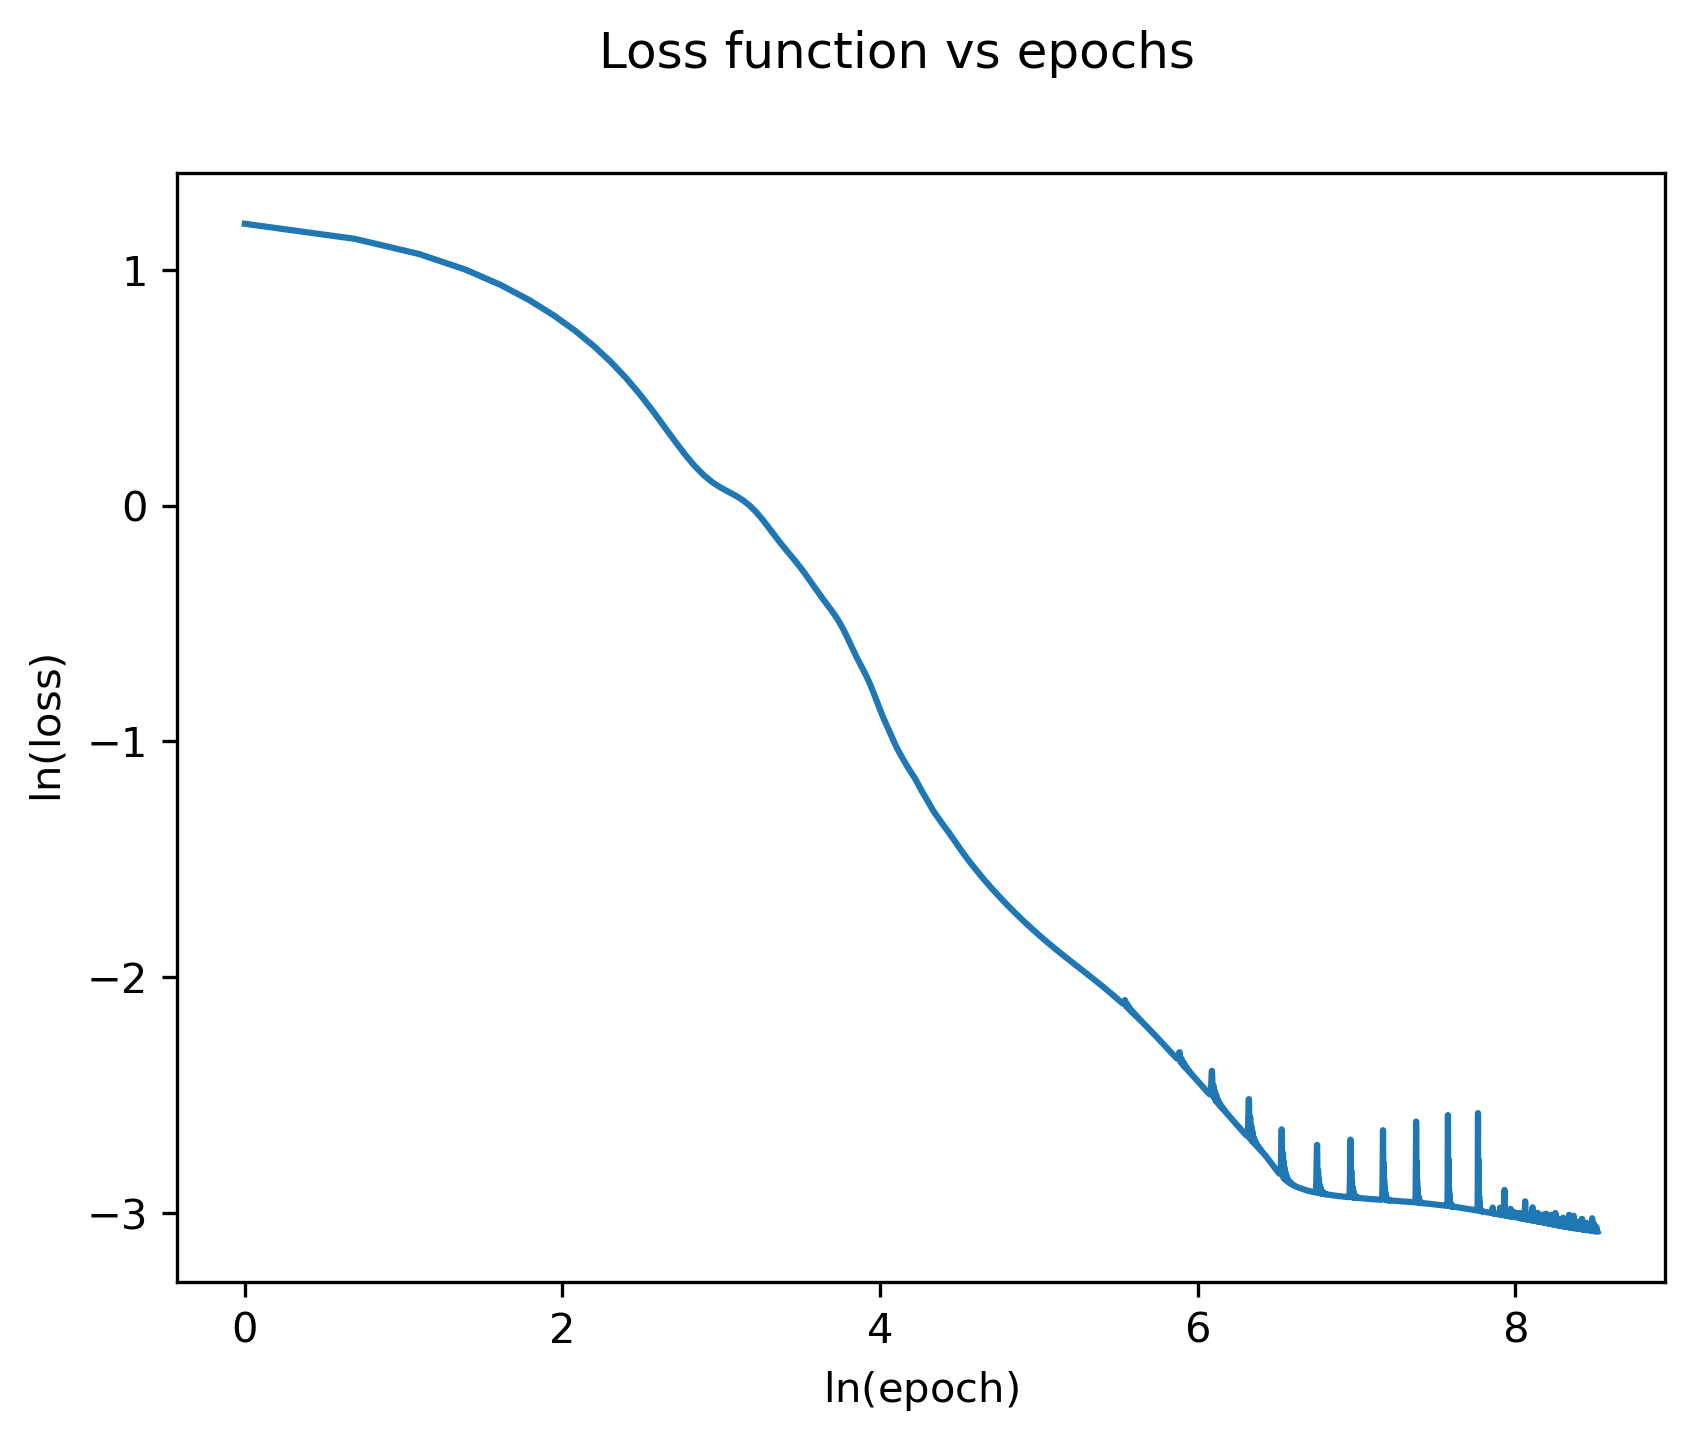

In [27]:
loss_plot(lin1);

In [28]:
alpha = 0.5*torch.pow(off_diff*pde_params['eta'],2)
sol_lin = exp_solution(pde_params, alpha)
display_it(lin1,closed_form=sol_lin);

The $L^2$ distance between the fitted value function at time 0 and closed-form is  1.128E-03.
The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  1.782E-03.


In [29]:
for t in [0.,0.5,1.]:
    display_it(lin1,closed_form=sol_lin,t=t,zlim=[-0.2,0.5]);

The $L^2$ distance between the fitted value function at time 0.00 and closed-form is  1.148E-03.
The $L^2$ distance between the fitted value function at time 0.50 and closed-form is  3.317E-04.
The $L^2$ distance between the fitted value function at time 1.00 and closed-form is  4.820E-04.


Range of $\hat\eta=-\dfrac{\hat{v}_w}{\hat{v}_{ww}}$

In [30]:
for i in range(sim_params['num_time_intervals']):
    d1,d2 = Grad_Hess(lin1.x[:,:,i],lin1.Yt)
    if i == 0:
        eta_app = -d2[:,1,1]/d1[:,1].squeeze(-1)
    else:
        eta_app = torch.cat((eta_app,-d2[:,1,1]/d1[:,1].squeeze(-1)),axis=0)
eta_app.shape,eta_app.min(),eta_app.mean(),eta_app.median(),eta_app.max(),eta_app.std()

(torch.Size([5120]),
 tensor(-14.7074, grad_fn=<MinBackward1>),
 tensor(0.9284, grad_fn=<MeanBackward0>),
 tensor(0.9469, grad_fn=<MedianBackward0>),
 tensor(20.0547, grad_fn=<MaxBackward1>),
 tensor(0.5669, grad_fn=<StdBackward0>))

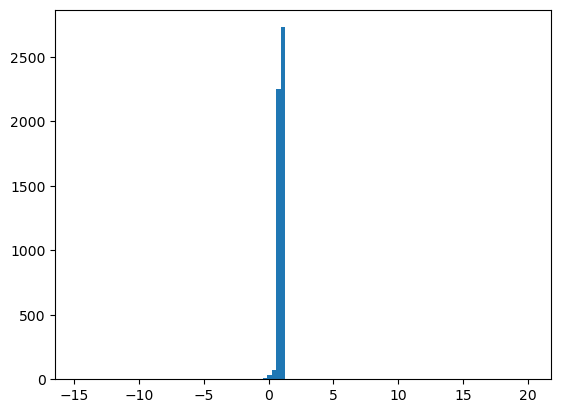

In [31]:
plt.hist(eta_app.clone().detach().numpy(),bins=100);

In [32]:
for i in range(sim_params['num_time_intervals']):
    d1 = Grad(lin1.x[:,:,i],lin1.Yt)
    d0 = lin1.Yt(lin1.x[:,:,i])
    if i == 0:
        eta_app = -d1[:,1]/(d0.squeeze(-1)-1)
    else:
        eta_app = torch.cat((eta_app,-d1[:,1]/(d0.squeeze(-1)-1)),axis=0)
eta_app.shape,eta_app.min(),eta_app.mean(),eta_app.median(),eta_app.max(),eta_app.std()

(torch.Size([5120, 512]),
 tensor(0.0036, grad_fn=<MinBackward1>),
 tensor(1.6462, grad_fn=<MeanBackward0>),
 tensor(0.9855, grad_fn=<MedianBackward0>),
 tensor(217.1740, grad_fn=<MaxBackward1>),
 tensor(2.5170, grad_fn=<StdBackward0>))

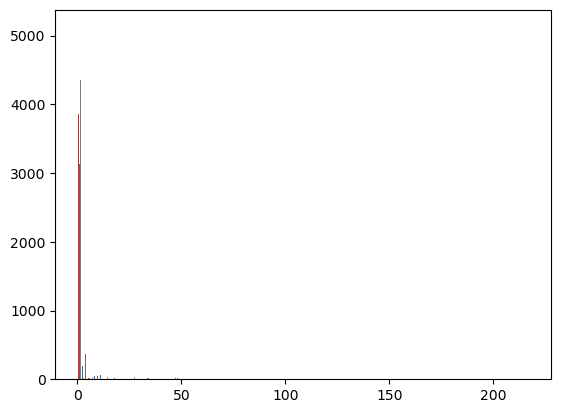

In [33]:
plt.hist(eta_app.clone().detach().numpy(),bins=100);

## Test 2

$\mu=$ OU with first component zero, $\sigma=1$, $\kappa=0$, $f=-1$, and terminal $0$

$\begin{cases}-v_t-\frac12\sigma^2v_{ww}-\mathcal{L}^Yv+f=0\\ v(e,y,T)=0\end{cases}$

Closed-from is $v(w,y,t)=\alpha (T-t)$ with $\alpha=1$



In [34]:
mu = OU_drift_semi(pde_params)
off_diff = torch.tensor([1.0]) #choose larger diffusion coef to make the difference between the terminal and time-zero solution larger
sigma = custom_diff(pde_params,off_diff)# With large constant_diff the trainning sucks!
k = zero_discount(pde_params)
off_source = torch.tensor([-1.0])
f = custom_source(pde_params,off_source)
g = zero_terminal(pde_params)

In [35]:
lin2 = linear(sigma,mu,f,k,g,pde_params,sim_params)

In [36]:
lin2.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 2.24E+00.
Training this epoch takes 8.74 ms. So far: 8.99 ms in training.
At epoch 1666, mean loss is 4.94E-06.
Training this epoch takes 3.68 ms. So far: 6,212.94 ms in training.
Training took 3147 epochs and 11,634.78 ms and the final loss is 1.77E-06.


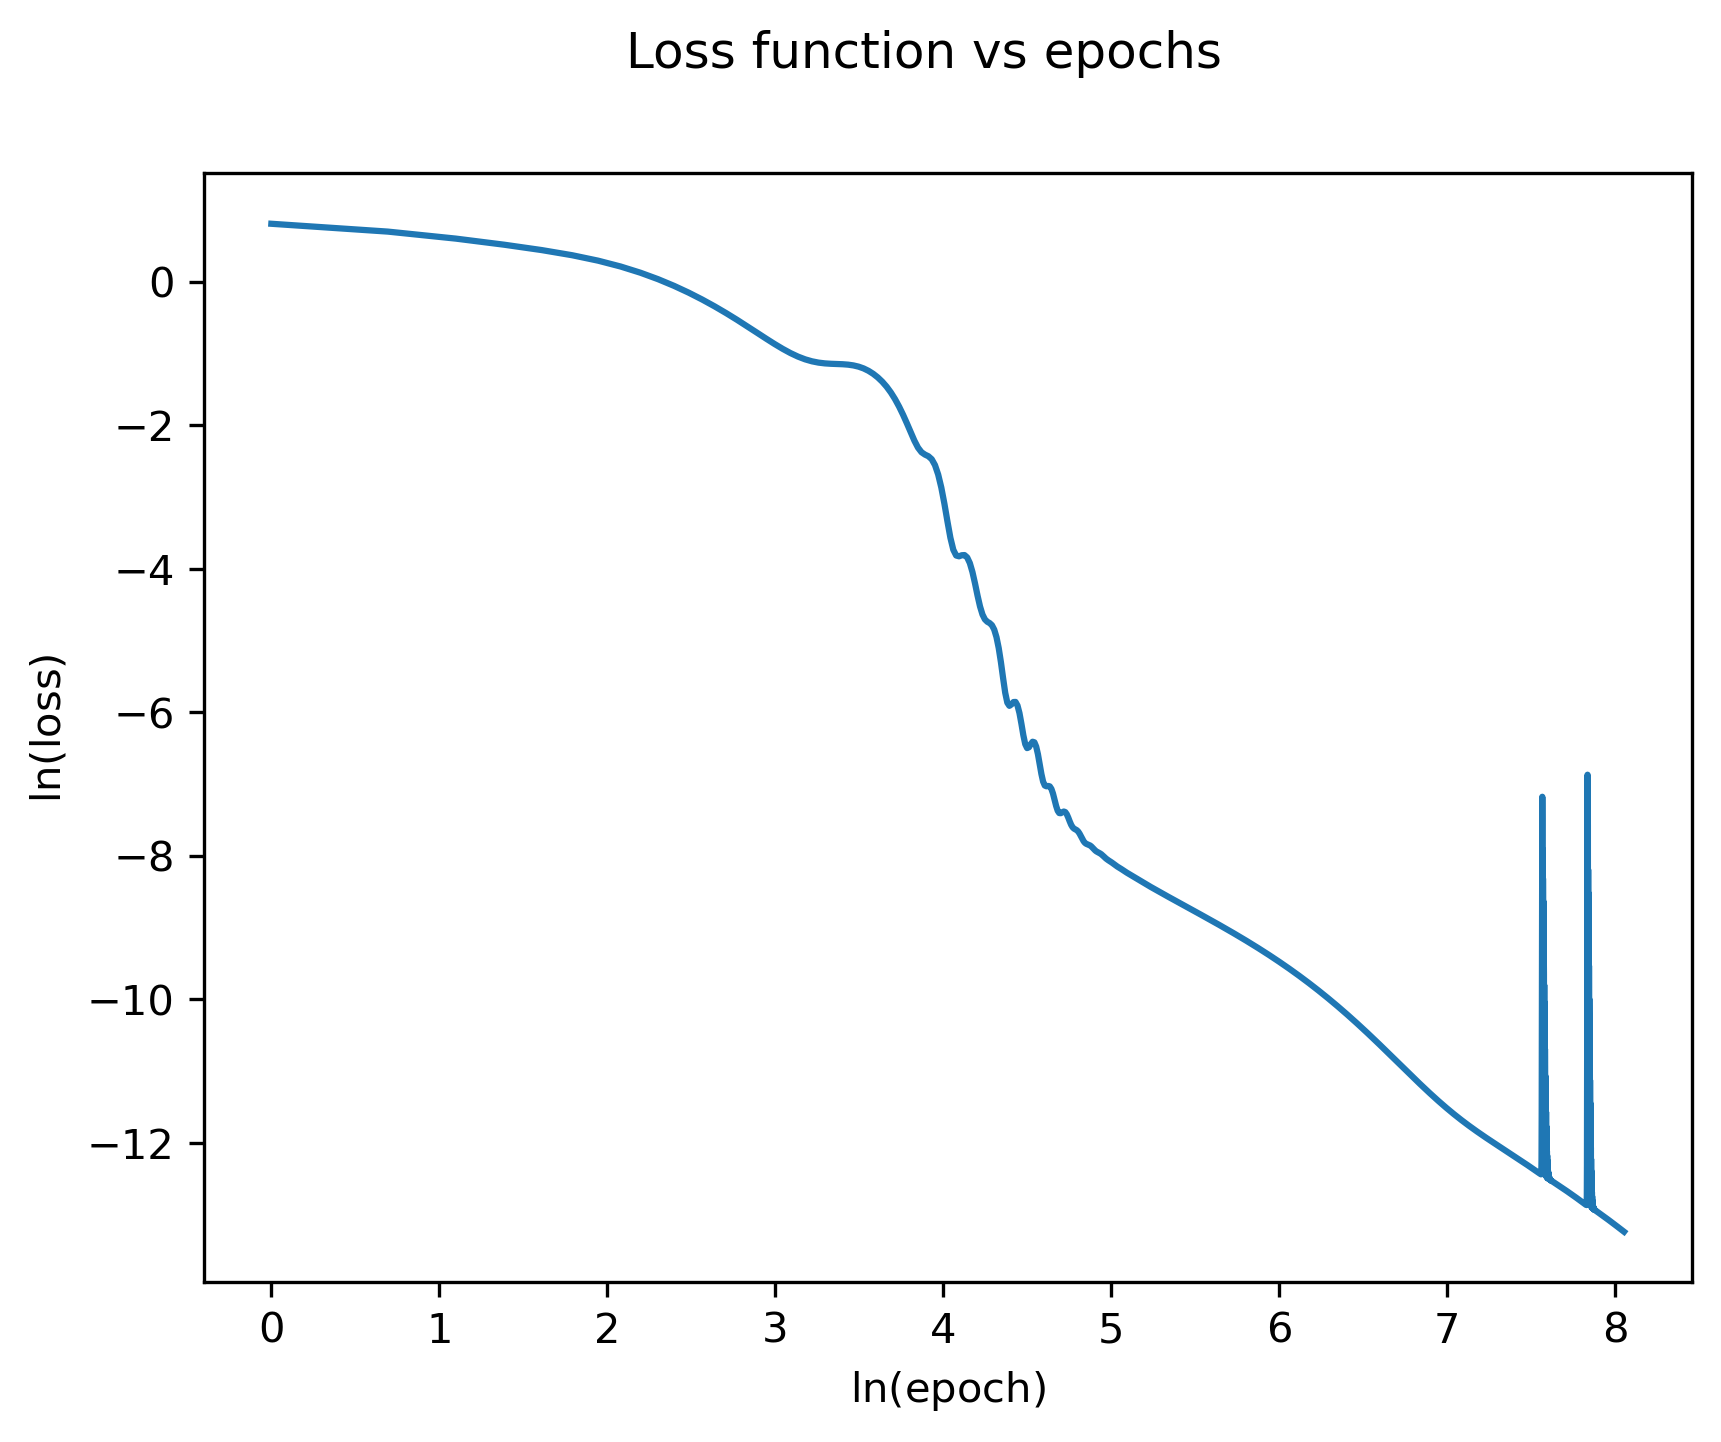

In [37]:
loss_plot(lin2);

In [38]:
alpha = 1.0
sol_lin = time_solution(pde_params, alpha)
display_it(lin2,closed_form=sol_lin,zlim=[0.0,1.0]);

The $L^2$ distance between the fitted value function at time 0 and closed-form is  3.549E-07.
The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  6.361E-07.


In [39]:
for t in [0.,0.5,1.]:
    display_it(lin2,closed_form=sol_lin,t=t,zlim=[0.0,1.0]);

The $L^2$ distance between the fitted value function at time 0.00 and closed-form is  3.528E-07.
The $L^2$ distance between the fitted value function at time 0.50 and closed-form is  3.796E-03.
The $L^2$ distance between the fitted value function at time 1.00 and closed-form is  6.372E-06.


## Test 3 (Semilinear w optimal $\sigma$)

$\mu=$ OU with first component zero, $\sigma=\frac{|\lambda|}{\eta}$, $\kappa=0$, and terminal $1-\exp(-\eta w)$

$\begin{cases}-v_t-\frac12\sigma^2v_{ww}-\mathcal{L}^Yv-|\lambda|\sigma |v_w|=0\\ v(e,y,T)=0\end{cases}$

Closed-from is $v(w,y,t)=1-\exp\left(-\eta w+\alpha(T-t)\right)$ with $\alpha=-\frac12|\lambda|^2$


In [40]:
m = OU_drift_semi(pde_params)
optimal_diff = m.lb_norm/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

In [41]:
optimal_diff

tensor([1.6081])

In [42]:
semi_opt = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

In [43]:

semi_opt.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 4.70E+01.
Training this epoch takes 15.21 ms. So far: 15.64 ms in training.
At epoch 1666, mean loss is 2.26E+00.
Training this epoch takes 4.73 ms. So far: 7,644.48 ms in training.
At epoch 3332, mean loss is 8.11E-01.
Training this epoch takes 4.75 ms. So far: 15,619.63 ms in training.
At epoch 4998, mean loss is 5.04E-01.
Training this epoch takes 4.59 ms. So far: 23,726.06 ms in training.
Training took 5000 epochs and 23,735.59 ms and the final loss is 5.29E-01.


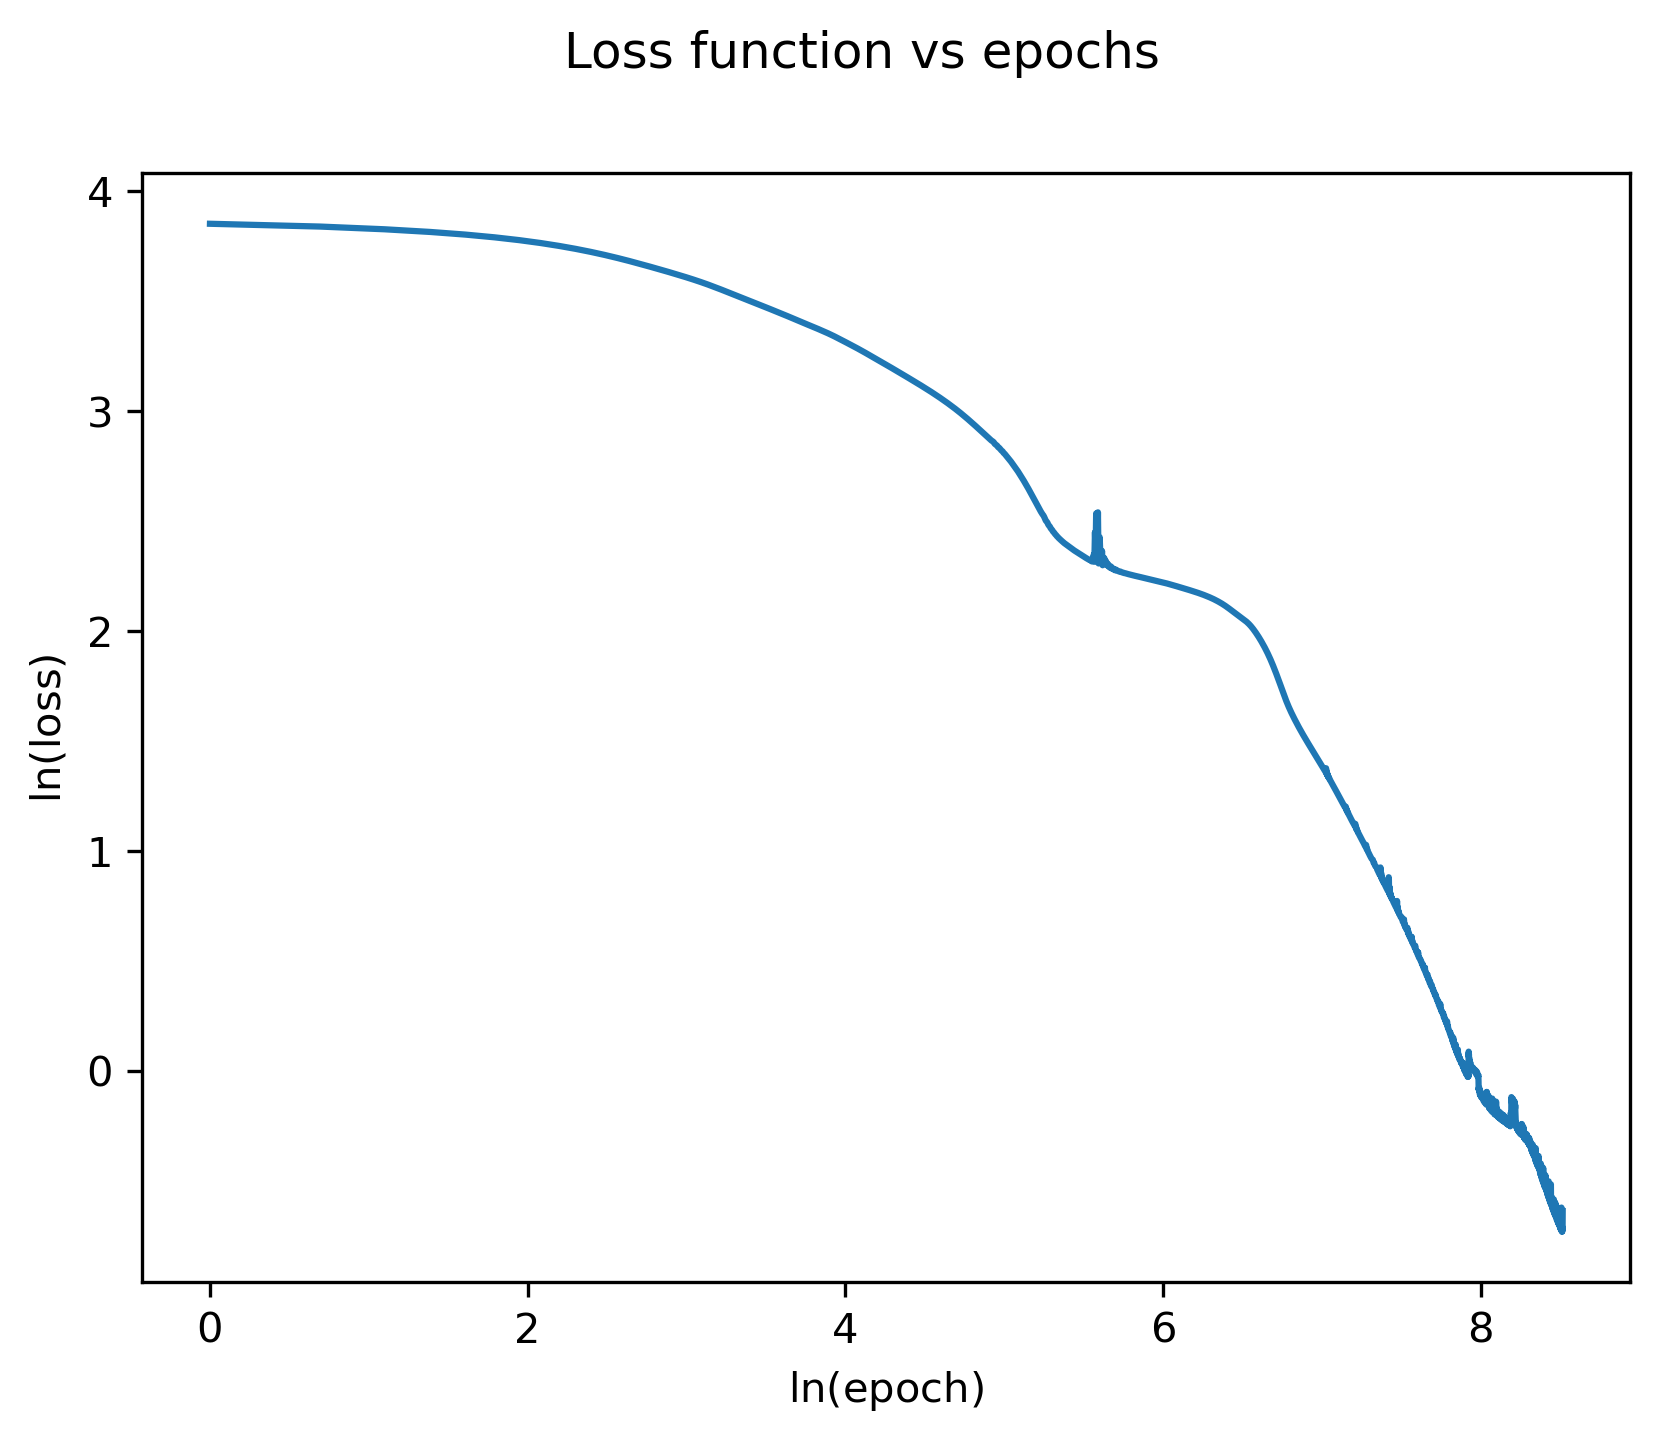

In [44]:
loss_plot(semi_opt);

In [45]:
alpha = -0.5*torch.pow(pde_params['lb'][0:pde_params['dim']],2).sum()
sol_semi = exp_solution(pde_params,alpha)
display_it(semi_opt,closed_form=sol_semi,zlim=[0.0,1.0]);

The $L^2$ distance between the fitted value function at time 0 and closed-form is  1.347E-03.
The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  3.475E-01.


In [46]:
for t in [.0,.5,1.]:
    display_it(semi_opt,closed_form=sol_semi,t=t,zlim=[0.0,1.0]);

The $L^2$ distance between the fitted value function at time 0.00 and closed-form is  1.363E-03.
The $L^2$ distance between the fitted value function at time 0.50 and closed-form is  4.536E-03.
The $L^2$ distance between the fitted value function at time 1.00 and closed-form is  2.485E-03.


## Test 4 (Semilinear w random $\sigma$)

$\mu=$ OU with first component zero, $\sigma=Unif(0,1)$, $\kappa=0$, $f=-1$, and terminal $1-\exp(-\eta w)$

$\begin{cases}-v_t-\frac12\sigma^2v_{ww}-\mathcal{L}^Yv-|\lambda|\sigma |v_w|=0\\ v(e,y,T)=0\end{cases}$

Closed-from is $v(w,y,t)=1-\exp\left(-\eta w+\alpha(T-t)\right)$ with $\alpha=\sigma\eta^2\left(\frac12\sigma-\frac{|\lambda|}{\eta}\right)$


In [47]:
m = OU_drift_semi(pde_params)
rand_tensor = torch.rand(1)
rand_diff = custom_diff(pde_params,rand_tensor)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

In [48]:
semi_rand = semilinear(rand_diff,m,F,k,g,pde_params,sim_params)

In [49]:
semi_rand.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 8.33E-01.
Training this epoch takes 9.52 ms. So far: 9.84 ms in training.
At epoch 1666, mean loss is 7.62E-05.
Training this epoch takes 5.01 ms. So far: 7,942.95 ms in training.
Training took 2102 epochs and 10,034.79 ms and the final loss is 7.22E-05.


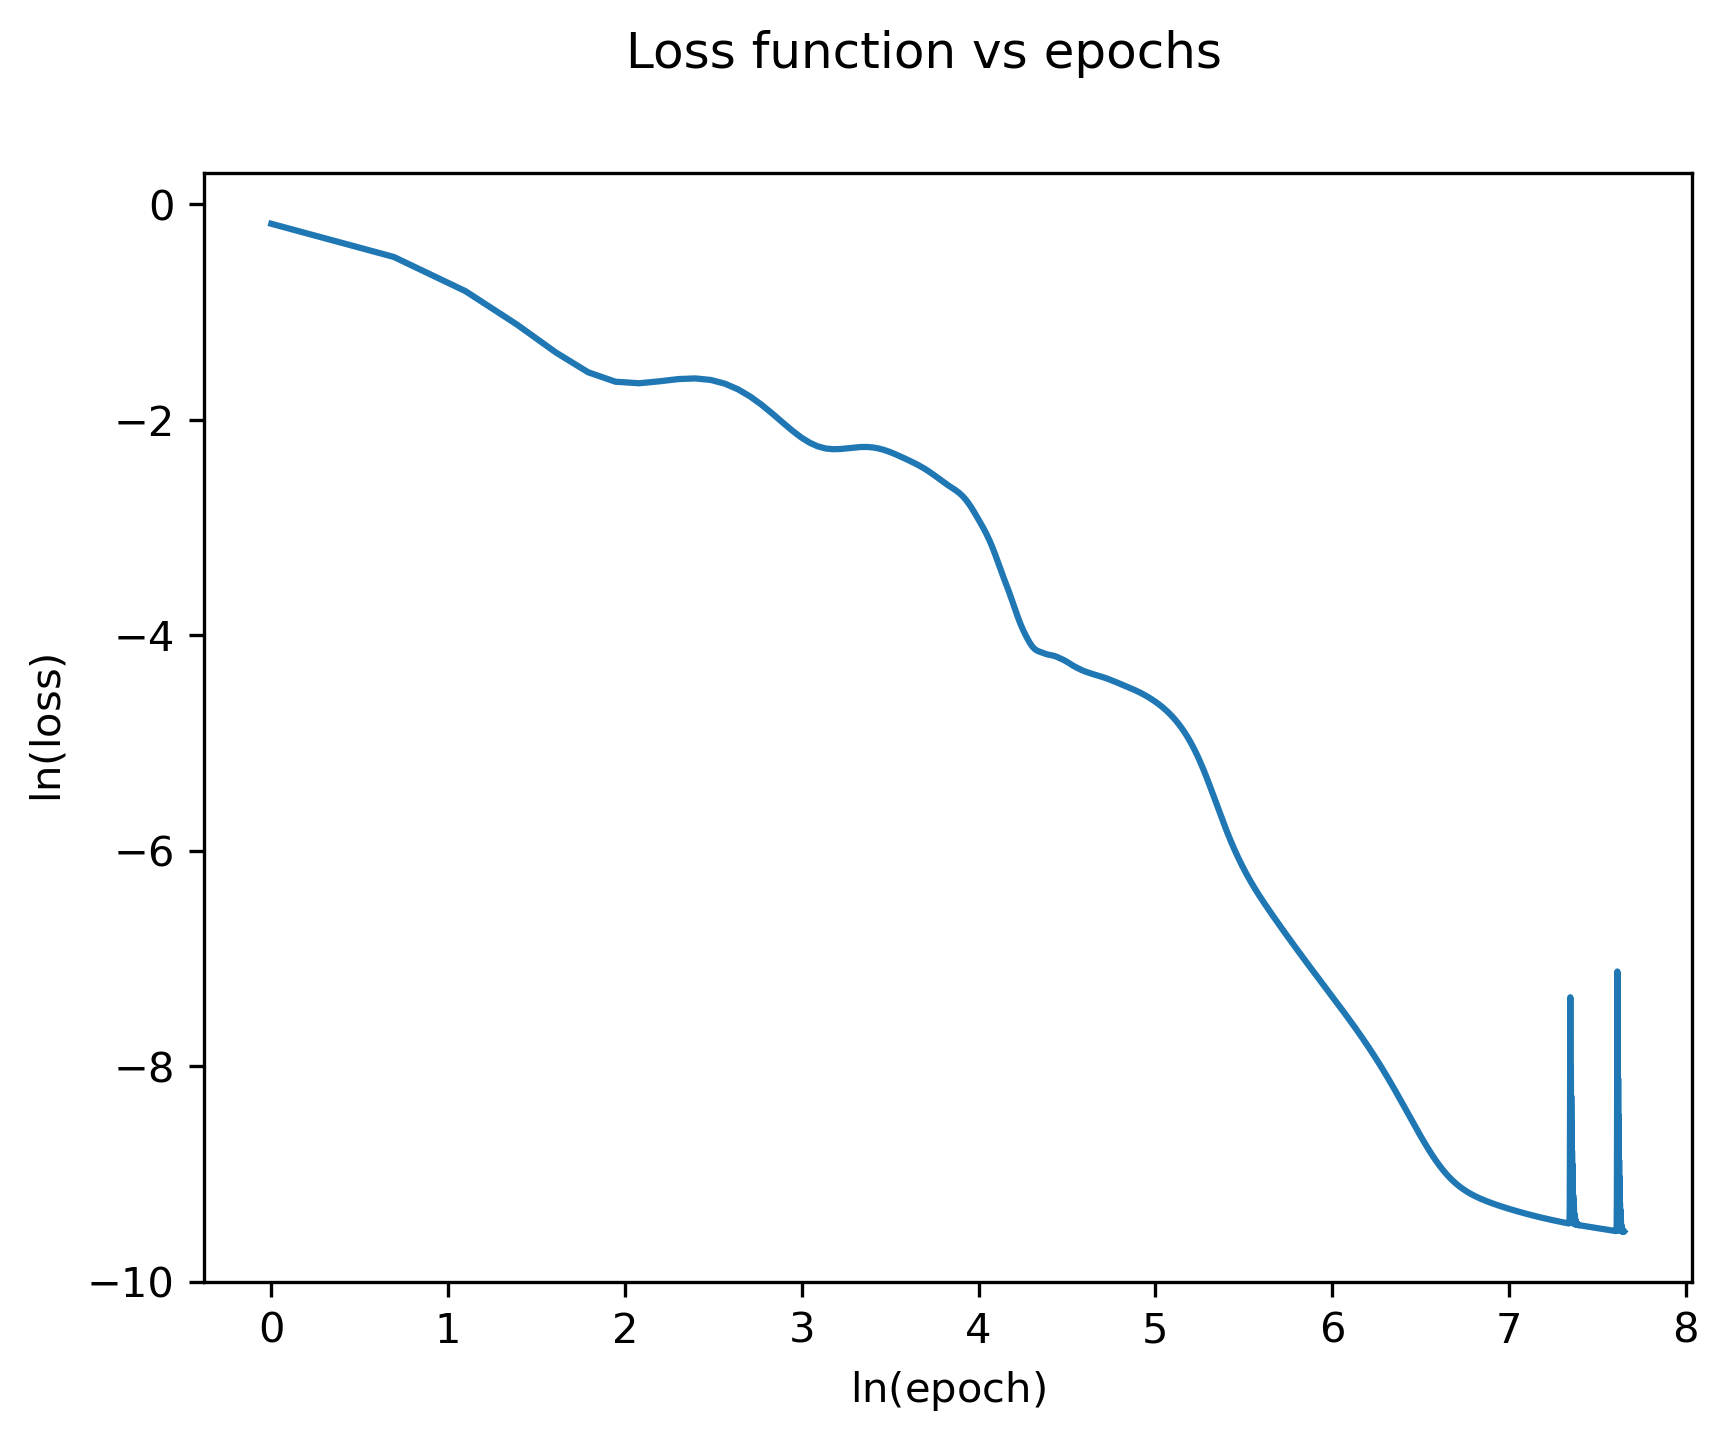

In [50]:
loss_plot(semi_rand);

In [51]:
alpha = rand_tensor*pde_params['eta']*(0.5*rand_tensor*pde_params['eta']-torch.sqrt(torch.pow(pde_params['lb'][0:pde_params['dim']],2).sum()))
sol_semi = exp_solution(pde_params,alpha)
display_it(semi_rand,closed_form=sol_semi);

The $L^2$ distance between the fitted value function at time 0 and closed-form is  8.740E-06.
The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  1.407E-05.


In [52]:
for t in [0,.5,1.]:
    display_it(semi_rand,closed_form=sol_semi,t=t,zlim=[0.,.5]);

The $L^2$ distance between the fitted value function at time 0.00 and closed-form is  8.569E-06.
The $L^2$ distance between the fitted value function at time 0.50 and closed-form is  1.258E-05.
The $L^2$ distance between the fitted value function at time 1.00 and closed-form is  3.990E-06.


# End